# License

***

Copyright 2018-2019 Lingyao Meng (danielle@h2o.ai), J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

**DISCLAIMER:** This notebook is not legal compliance advice.

# Partial Dependence, Individual Conditional Expectation, and Surrogate Models

#### Python imports
In general, NumPy and Pandas will be used for data manipulation purposes and H2o and XGBoost will be used for modeling tasks.

In [1]:
# for handling external processes to generate PNG file of decision tree
import os
import time
import sys
import re
import subprocess

# in-notebook display of decision tree
from IPython.display import Image
from IPython.display import display

# to generate synthetic data w/ known interactions
from data_maker_and_getter import DataMakerAndGetter

import h2o                                                        # Python API for h2o library and server 
from h2o.estimators.random_forest import H2ORandomForestEstimator # h2o, for single tree
from h2o.backend import H2OLocalServer                            # h2o, for plotting local tree in-notebook

import matplotlib.pyplot as plt                                   # basic plotting
%matplotlib inline

import numpy as np                                                # basic math and array and matrix handling 
import pandas as pd                                               # basic Dataframe handling
import xgboost as xgb                                             # for training gradient boosting machines 

#### Start H2O server

In [2]:
h2o.init(max_mem_size='2G') # start server, allocate RAM
h2o.remove_all()            # delete any existing data structures in server, best practice

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_201"; Java(TM) SE Runtime Environment (build 1.8.0_201-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpk0snj6eo
  JVM stdout: /tmp/tmpk0snj6eo/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpk0snj6eo/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,15 days
H2O cluster name:,H2O_from_python_patrickh_s01bpc
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


#### Dataset with Known Signal Generating Functions

Create dataset with a known signal generating function with noise: 

$$ y = x_1 * x_4 + |x_8| * (x_9)^2 + e $$

## Data Generation and XGBoost Training

Generate synthetic data with:
* 200,000 rows
* Binary target
* A single, known signal-generating function (see above)
* With noise via label switching

In [3]:
ds_ = DataMakerAndGetter(nrows=200000, target='binary', one_function=True, noise=True)
rson = ds_.make_random_with_signal()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Histogram of important variable in generated data

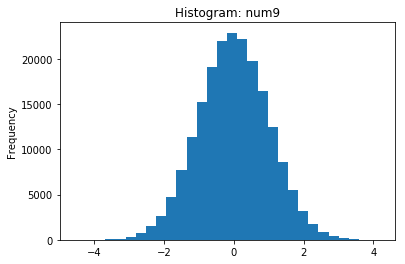

In [4]:
rson_pd = rson.as_data_frame()
_ = rson_pd['num9'].plot(kind='hist', bins=30, title='Histogram: num9')

#### Assign modeling roles

In [5]:
y = 'target'
X = [name for name in rson.columns if name not in [y,'row_id','function','cat1','cat2','cat3']]
print(X)

['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12']


#### Split data into training and validation set

In [6]:
rson[y] = rson[y].asfactor()
train, valid, _ = rson.split_frame([0.4, 0.3], seed = 12345)
print(train.shape)
print(valid.shape)

(80049, 18)
(59947, 18)


#### Convert h2o frame into Pandas Dataframe for various activites below

In [7]:
rsontrain_pd = train.as_data_frame()
rsonvalid_pd = valid.as_data_frame()

#### Convert Pandas Dataframes into XGBoost DMatrices (LightSVM format), required for training XGBoost

In [8]:
rsontrain_dm = xgb.DMatrix(rsontrain_pd[X],
                           rsontrain_pd[y])
rsonvalid_dm = xgb.DMatrix(rsonvalid_pd[X],
                           rsonvalid_pd[y])

#### Use average of y as XGBoost null model

In [9]:
ave_y = rsontrain_pd['target'].mean()
print(ave_y)

0.42154180564404303


#### Train XGBoost GBM
Hyperparameters selected by Cartesian grid search: https://gist.github.com/jphall663/705595e3bc72e8fdfee8fa56220503a5

In [10]:
params = {
     'base_score': ave_y,
     'booster': 'gbtree',
     'colsample_bytree': 0.9,
     'eta': 0.01,
     'eval_metric': 'auc',
     'max_depth': 12,
     'nthread': 4,
     'objective': 'binary:logistic',
     'reg_alpha': 0.001,
     'reg_lambda': 0.01,
     'seed': 12345,
     'silent': 0,
     'subsample': 0.1}

watchlist = [(rsontrain_dm, 'train'), (rsonvalid_dm, 'eval')]

rson_model = xgb.train(params, 
                       rsontrain_dm, 
                       400,
                       early_stopping_rounds=50,
                       evals=watchlist, 
                       verbose_eval=True)

[0]	train-auc:0.662655	eval-auc:0.637728
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.701792	eval-auc:0.669751
[2]	train-auc:0.756935	eval-auc:0.722574
[3]	train-auc:0.792702	eval-auc:0.758416
[4]	train-auc:0.814924	eval-auc:0.782046
[5]	train-auc:0.81665	eval-auc:0.782009
[6]	train-auc:0.826115	eval-auc:0.79378
[7]	train-auc:0.829857	eval-auc:0.797381
[8]	train-auc:0.831158	eval-auc:0.798757
[9]	train-auc:0.832994	eval-auc:0.801017
[10]	train-auc:0.83283	eval-auc:0.799187
[11]	train-auc:0.836437	eval-auc:0.80342
[12]	train-auc:0.836729	eval-auc:0.802991
[13]	train-auc:0.839226	eval-auc:0.806378
[14]	train-auc:0.840314	eval-auc:0.808367
[15]	train-auc:0.841832	eval-auc:0.81027
[16]	train-auc:0.843173	eval-auc:0.8109
[17]	train-auc:0.843384	eval-auc:0.810746
[18]	train-auc:0.844492	eval-auc:0.812145
[19]	train-auc:0.845608	eval-auc:0.813533
[20]	train-auc:0.845638	eval-auc:0.8

[191]	train-auc:0.875243	eval-auc:0.821628
[192]	train-auc:0.875285	eval-auc:0.821636
[193]	train-auc:0.875431	eval-auc:0.82174
[194]	train-auc:0.87557	eval-auc:0.821793
[195]	train-auc:0.87559	eval-auc:0.821794
[196]	train-auc:0.875616	eval-auc:0.821846
[197]	train-auc:0.87576	eval-auc:0.821851
[198]	train-auc:0.875841	eval-auc:0.821877
[199]	train-auc:0.875861	eval-auc:0.821877
[200]	train-auc:0.876006	eval-auc:0.821913
[201]	train-auc:0.876058	eval-auc:0.821966
[202]	train-auc:0.876177	eval-auc:0.821929
[203]	train-auc:0.876354	eval-auc:0.821938
[204]	train-auc:0.876465	eval-auc:0.82192
[205]	train-auc:0.876617	eval-auc:0.822009
[206]	train-auc:0.876719	eval-auc:0.822077
[207]	train-auc:0.876908	eval-auc:0.82217
[208]	train-auc:0.877023	eval-auc:0.822187
[209]	train-auc:0.877167	eval-auc:0.822194
[210]	train-auc:0.877189	eval-auc:0.822159
[211]	train-auc:0.877284	eval-auc:0.822168
[212]	train-auc:0.877436	eval-auc:0.822174
[213]	train-auc:0.877567	eval-auc:0.822214
[214]	train-auc:0

[383]	train-auc:0.892321	eval-auc:0.823225
[384]	train-auc:0.89238	eval-auc:0.823224
[385]	train-auc:0.892507	eval-auc:0.823215
[386]	train-auc:0.892617	eval-auc:0.82319
[387]	train-auc:0.892649	eval-auc:0.82321
[388]	train-auc:0.892674	eval-auc:0.823212
[389]	train-auc:0.89271	eval-auc:0.823205
[390]	train-auc:0.892739	eval-auc:0.823216
[391]	train-auc:0.892819	eval-auc:0.823202
[392]	train-auc:0.892898	eval-auc:0.823223
[393]	train-auc:0.893005	eval-auc:0.823223
[394]	train-auc:0.893051	eval-auc:0.823198
[395]	train-auc:0.893092	eval-auc:0.823163
[396]	train-auc:0.893113	eval-auc:0.823163
[397]	train-auc:0.893189	eval-auc:0.823159
[398]	train-auc:0.893237	eval-auc:0.823173
[399]	train-auc:0.893294	eval-auc:0.823183


## Calculate and Display Partial Dependence and ICE Curves

#### Function for calculating partial dependence and ICE

In [11]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

#### Calculate partial dependence for the most important input variables in the GBM

In [12]:
par_dep_num9 = par_dep('num9', rsonvalid_pd[X], rson_model)

#### Display partial dependence for important variable

In [13]:
par_dep_num9

,num9,partial_dependence
0,-4.080806,0.764284
1,-3.682671,0.764284
2,-3.284536,0.764284
3,-2.886401,0.766352
4,-2.488266,0.758818
5,-2.090131,0.706026
6,-1.691996,0.679998
7,-1.293861,0.575561
8,-0.895725,0.450925
9,-0.497590,0.297198


#### Bind XGBoost predictions to training data and display

In [14]:
rson_preds = pd.DataFrame(rson_model.predict(rsonvalid_dm))
rson_decile_frame = pd.concat([rsonvalid_pd, rson_preds], axis=1)
rson_decile_frame = rson_decile_frame.rename(columns={0: 'predict'})
rson_decile_hframe = h2o.H2OFrame(rson_decile_frame)
rson_decile_frame.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,cat1,cat2,cat3,target,row_id,function,predict
0,0.274992,0.228913,1.352917,0.886429,-2.001637,-0.371843,1.669025,-0.438570,-0.539741,0.476985,3.248944,-1.021228,GGGGGGGG,CCCCCCCC,BBBBBBBB,0,1,1,0.290944
1,0.331286,1.349742,0.069877,0.246674,-0.011862,1.004812,1.327195,-0.919262,-1.549106,0.022185,0.758363,-0.660524,DDDDDDDD,AAAAAAAA,DDDDDDDD,1,4,1,0.826447
2,0.862580,-0.010032,0.050009,0.670216,0.852965,-0.955869,-0.023493,-2.304234,-0.652469,-1.218302,-1.332610,1.074623,BBBBBBBB,CCCCCCCC,AAAAAAAA,1,5,1,0.633627
3,0.723642,0.690002,1.001543,-0.503087,-0.622274,-0.921169,-0.726213,0.222896,0.051316,-1.157719,0.816707,0.433610,CCCCCCCC,GGGGGGGG,FFFFFFFF,0,6,1,0.143136
4,-2.252797,-1.166832,0.353607,0.702110,-0.274569,-0.139142,0.107657,-0.606545,-0.417064,-0.017007,-1.224145,-1.800840,FFFFFFFF,DDDDDDDD,CCCCCCCC,1,10,1,0.157180


#### Find percentiles of XGBoost predictions

In [15]:
rson_percentile_dict = ds_.get_percentile_dict('predict', 'row_id', rson_decile_hframe)

#### Display percentiles with row identifiers

In [16]:
rson_percentile_dict

{0: 137359,
 10: 95964,
 20: 148660,
 30: 73527,
 40: 127436,
 50: 95138,
 60: 190656,
 70: 162259,
 80: 101443,
 90: 55938,
 99: 191654}

#### Calculate ICE curve values

In [17]:
# retreive bins from original partial dependence calculation
bins_num9 = list(par_dep_num9['num9'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(rson_percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for num11 across percentiles at bins_num11 intervals
    par_dep_num9[col_name] = par_dep('num9', 
                                     rsonvalid_pd[rsonvalid_pd['row_id'] == int(rson_percentile_dict[i])][X], 
                                     rson_model, 
                                     bins=bins_num9)['partial_dependence']


#### Display partial dependence and ICE for num9 -- all calculated DIRECTLY from the XGBoost model

In [18]:
par_dep_num9

,num9,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-4.080806,0.764284,0.515088,0.458600,0.810318,0.839874,0.727913,0.733273,0.890809,0.759960,0.841190,0.849099,0.923298
1,-3.682671,0.764284,0.515088,0.458600,0.810318,0.839874,0.727913,0.733273,0.890809,0.759960,0.841190,0.849099,0.923298
2,-3.284536,0.764284,0.515088,0.458600,0.810318,0.839874,0.727913,0.733273,0.890809,0.759960,0.841190,0.849099,0.923298
3,-2.886401,0.766352,0.520794,0.464279,0.810370,0.842923,0.732415,0.737994,0.893012,0.764360,0.844218,0.849204,0.924900
4,-2.488266,0.758818,0.490112,0.446488,0.820998,0.847313,0.711169,0.733383,0.884938,0.762031,0.835098,0.853508,0.923788
5,-2.090131,0.706026,0.333122,0.345124,0.806049,0.758585,0.570403,0.678371,0.880654,0.716486,0.836961,0.837111,0.894585
6,-1.691996,0.679998,0.238474,0.276057,0.809211,0.726572,0.561841,0.691951,0.887216,0.694028,0.848665,0.860497,0.900010
7,-1.293861,0.575561,0.162722,0.163089,0.757918,0.455597,0.329458,0.714196,0.871064,0.474803,0.787196,0.870774,0.889968
8,-0.895725,0.450925,0.123221,0.183517,0.371279,0.290782,0.246867,0.568430,0.791420,0.428179,0.760115,0.865656,0.849518
9,-0.497590,0.297198,0.097429,0.148200,0.164114,0.156815,0.203267,0.301832,0.528376,0.255190,0.774756,0.814984,0.813392


#### Plot partial dependence and ICE

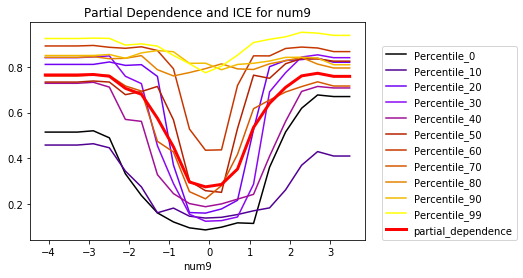

In [19]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

plot_par_dep_ICE('num9', par_dep_num9)

Notice the divergence of the ICE curves from the red partial dependence curve for `~-1 < num9 < ~1`. This divergence can be indicative of an interaction between input variables. The surrogate tree at the bottom of the notebook can provide further insight into which input variables are driving the detected interaction.

## Train and Display Surrogate Decision Tree

#### Train single h2o decision tree as surrogate between the XGBoost predictions and inputs

In [20]:
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=5,       # shallow trees are easier to understand
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y='predict', training_frame=rson_decile_hframe)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/patrickh/workspace/xai_guidelines/dt_surrogate_mojo.zip


#### Create GraphViz dot file of tree

In [21]:
# title for plot
title = 'Known Signal Data (with Validation) Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/workspace/xai_guidelines/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Known Signal Data (with Validation) Decision Tree Surrogate


#### Create PNG from GraphViz dot file and display

In [22]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


#### Display surrogate tree in-notebook
Double click to zoom.

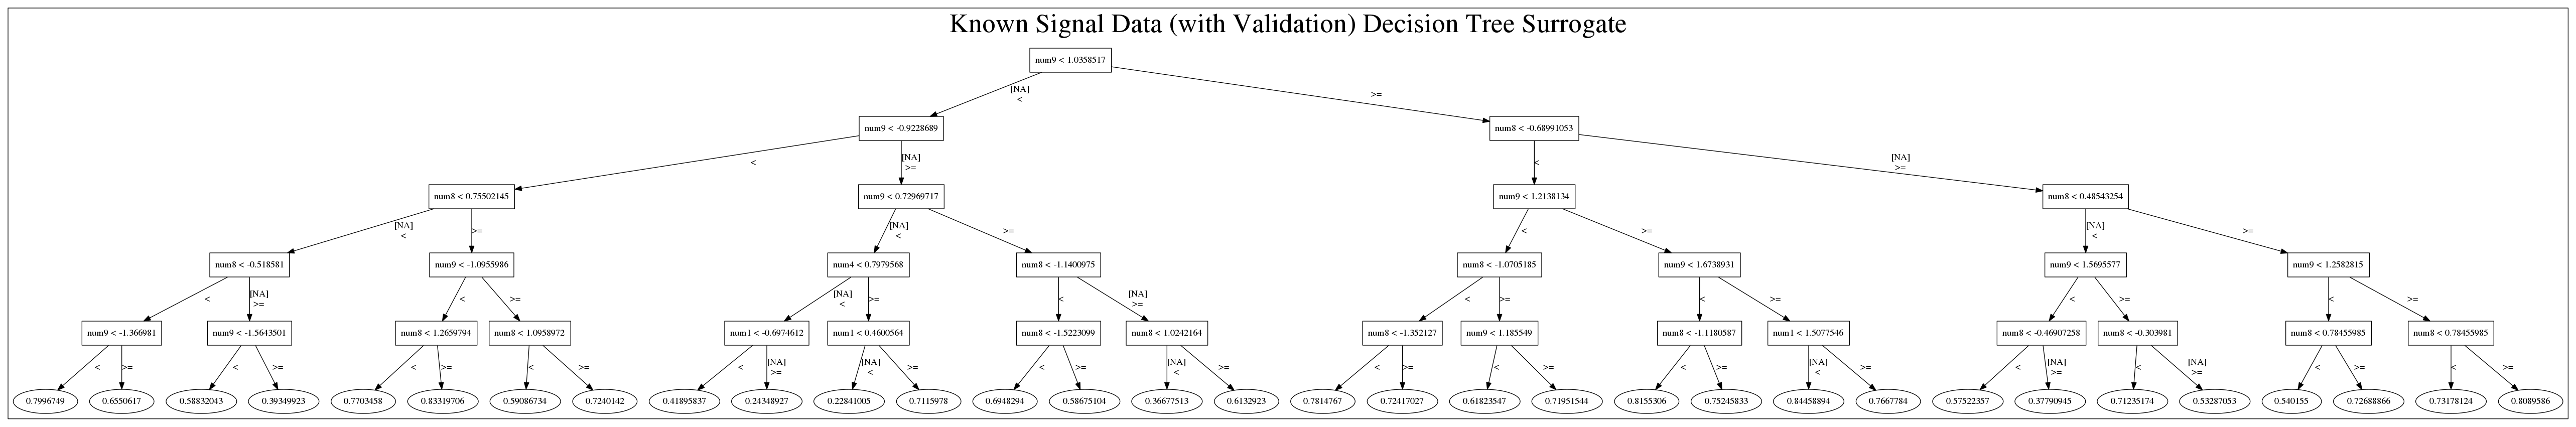

In [23]:
display(Image((png_file_name)))

In the decision tree above, there are parent-child node relationships between num9 and several other input variables for the range `~-1 < num9 < ~1`. These parent-child relationships can be indicative of the variables driving the interactions detected in the partial dependence and ICE plot above.


**Conclusion**: In this notebook, direct and indirect model explanation techniques were combined to gain insights into the behavior of a complex ML model. 